# Image Feature Extraction with Object Based Image Analysis (OBIA) 

- a) Spectral Features: capture radiometric properties of segments
    - Intensity mean: represents average spectral value for each band within a segment. Provides statistical summary of segments' radiometric properties
    - Standard Deviation: tells how much the values within a segment vary from the mean.

- b) Shape Features: provide information about the form and structure of segments. Useful for object detection and classification.
    - Retangularity: measure how close to a rectangle the segment cell is.
    - Compactness: measure how close to a circle the segment cell is.
    - Solidity: measure how "solid"/"filled" the shape is by comaring with the segment's area to its convex hull.

- c) Textural Features: important for analyzing the surface characteristics and patterns within an image.
    - Entropy: measures the degree of randomness or disorder in the pixel intensity values within a segment.

In [1]:
# imports
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import rasterio as rio
import earthpy.plot as ep

from matplotlib import rcParams
from scipy import stats
from skimage import graph
from skimage.color import label2rgb
from skimage.measure import regionprops, regionprops_table
from skimage.morphology import binary_dilation
from skimage.segmentation import mark_boundaries, slic
from skimage.util import map_array
from tqdm import tqdm


# set general figsize
rcParams['figure.figsize'] = (10,10)

In [2]:
image_path = "./images/Barcelona.tif"
with rio.open(image_path) as src:
    stack = src.read() #BGR red edge NIR
    metadata = src.profile.copy()


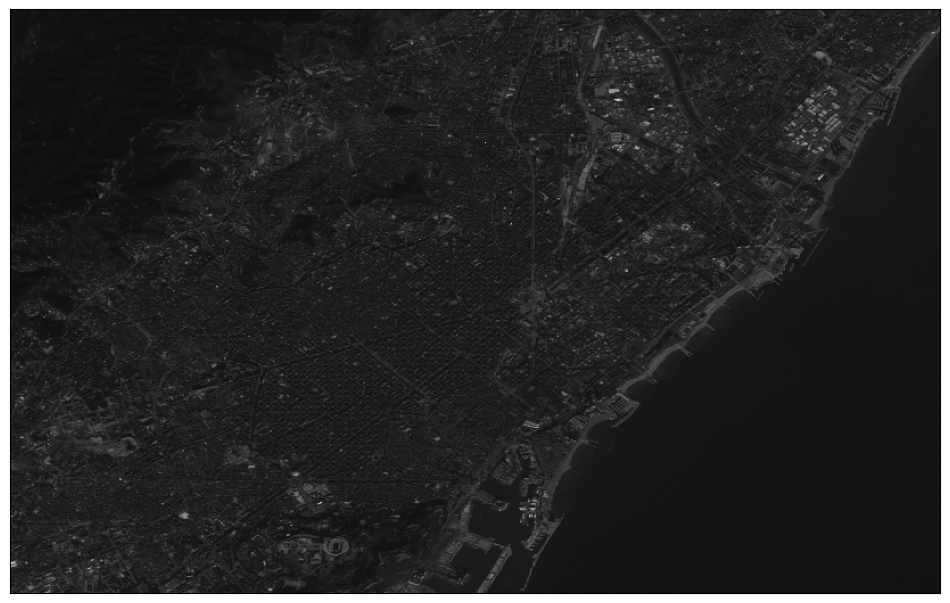

In [3]:
ep.plot_bands(stack[0,:,:], cbar = False)
plt.show()

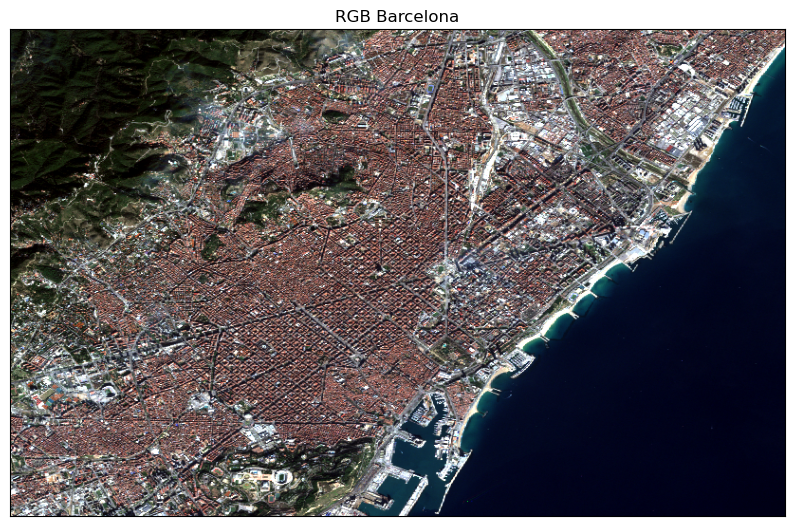

In [4]:
rgb = np.stack([stack[2,:, :], stack[1,:,:], stack[0, :,:]])

ep.plot_rgb(rgb, stretch=True, title = 'RGB Barcelona')
plt.show()

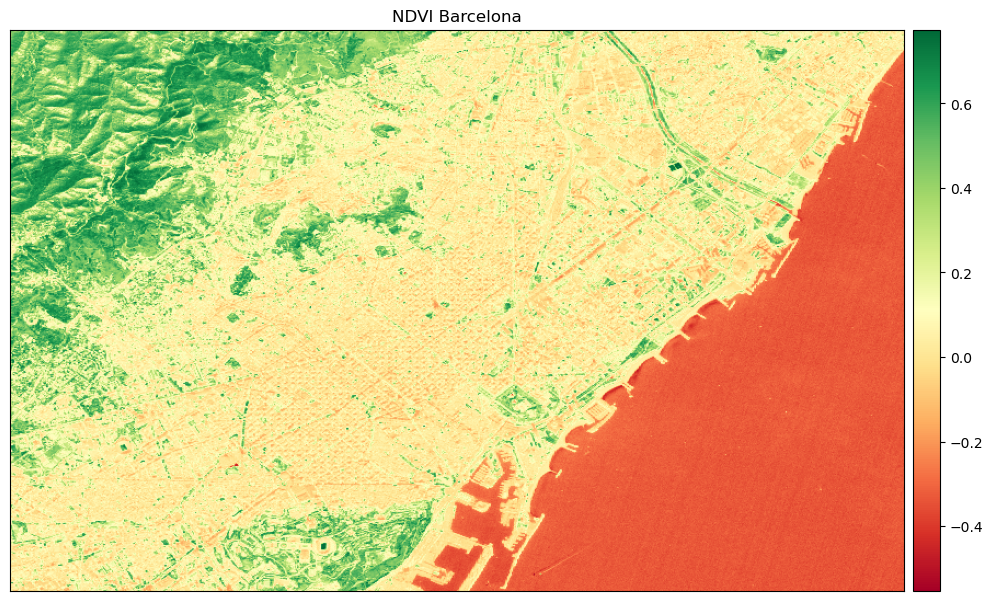

<Axes: title={'center': 'NDVI Barcelona'}>

In [5]:
ndvi = (stack[4,:,:] - stack[2, :,:])/(stack[4,:,:] + stack[2, :,:] + 1e-6)
ndvi = np.expand_dims(ndvi, axis = 0)


ep.plot_bands(ndvi, cmap = 'RdYlGn', title = 'NDVI Barcelona')

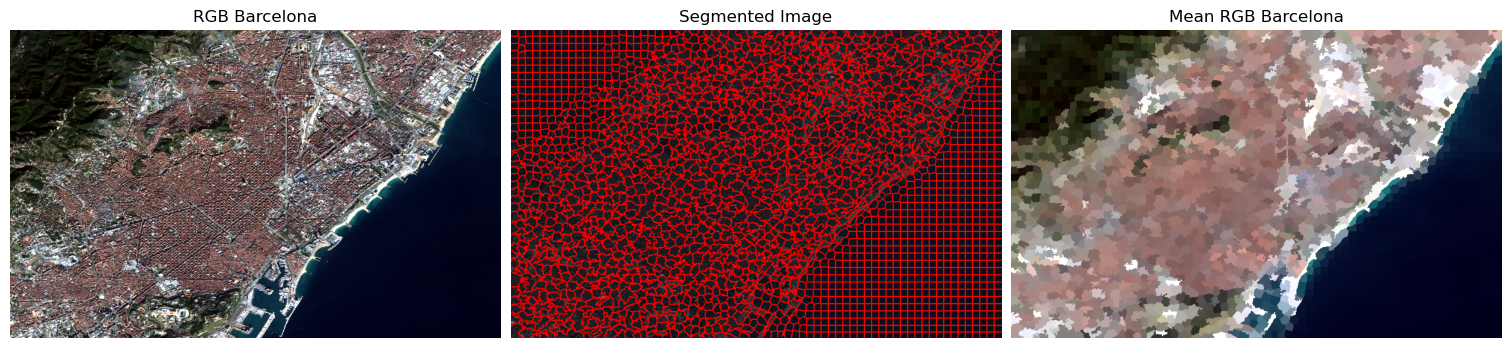

In [6]:
#Swaping dimentions to be used in skimage
rgb_hwb = np.transpose(rgb, axes=[1, 2, 0])


compactness = 4.5
n_segments = 3000

segments = slic(rgb_hwb, n_segments=n_segments, compactness=compactness, start_label=1)

fig, axs = plt.subplots(ncols = 3, figsize = (15,5), constrained_layout = True)

ep.plot_rgb(rgb, stretch=True, title = 'RGB Barcelona', ax = axs[0])


 # Segmentation boundaries plot
axs[1].imshow(
    mark_boundaries(
        rgb_hwb,  # Use the H, W, B formatted image
        segments,
        color=(1, 0, 0)
    )
)
axs[1].set_title("Segmented Image")

# Mean RGB per segment plot
mean_rgb = label2rgb(
        segments,
        rgb_hwb,  # Use the H, W, B formatted image
        kind="avg"
    )
mean_rgb = np.transpose(mean_rgb, axes = [2, 0, 1])

ep.plot_rgb(mean_rgb, stretch=True, title = 'Mean RGB Barcelona', ax = axs[2])


for ax in axs:
    ax.set_axis_off()

plt.show()


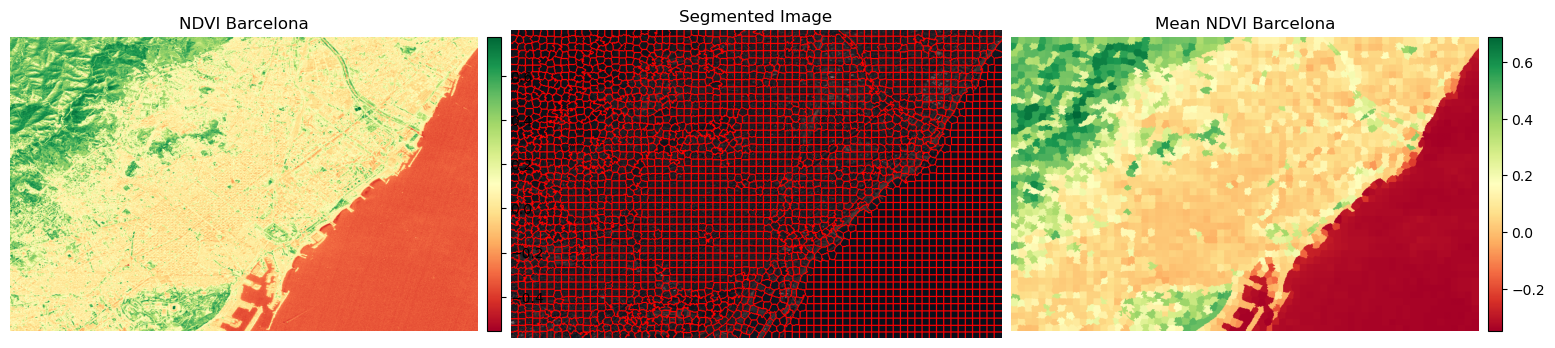

In [7]:
#Swaping dimentions to be used in skimage
ndvi_hwb = np.transpose(ndvi, axes=[1, 2, 0])


compactness = 0.3
n_segments = 3000

segments = slic(ndvi_hwb, n_segments=n_segments, compactness=compactness, start_label=1)

fig, axs = plt.subplots(ncols = 3, figsize = (15,5), constrained_layout = True)

ep.plot_bands(ndvi, cmap = 'RdYlGn', title = 'NDVI Barcelona', ax = axs[0])


 # Segmentation boundaries plot
axs[1].imshow(
    mark_boundaries(
        rgb_hwb,  # Use the H, W, B formatted image
        segments,
        color=(1, 0, 0)
    )
)
axs[1].set_title("Segmented Image")

# Mean RGB per segment plot
mean_ndvi = label2rgb(
        segments,
        ndvi_hwb,  # Use the H, W, B formatted image
        kind="avg"
    )
mean_ndvi = np.transpose(mean_ndvi, axes = [2, 0, 1])

ep.plot_bands(mean_ndvi[0],  cmap = 'RdYlGn',title = 'Mean NDVI Barcelona',ax = axs[2])


for ax in axs:
    ax.set_axis_off()

plt.show()


In [8]:
no_sea = np.where((mean_ndvi[0] > -0.2) & (mean_ndvi[0] < 0.15) , mean_ndvi[0], -9999)
#low_veg_area = no_sea < 0.15

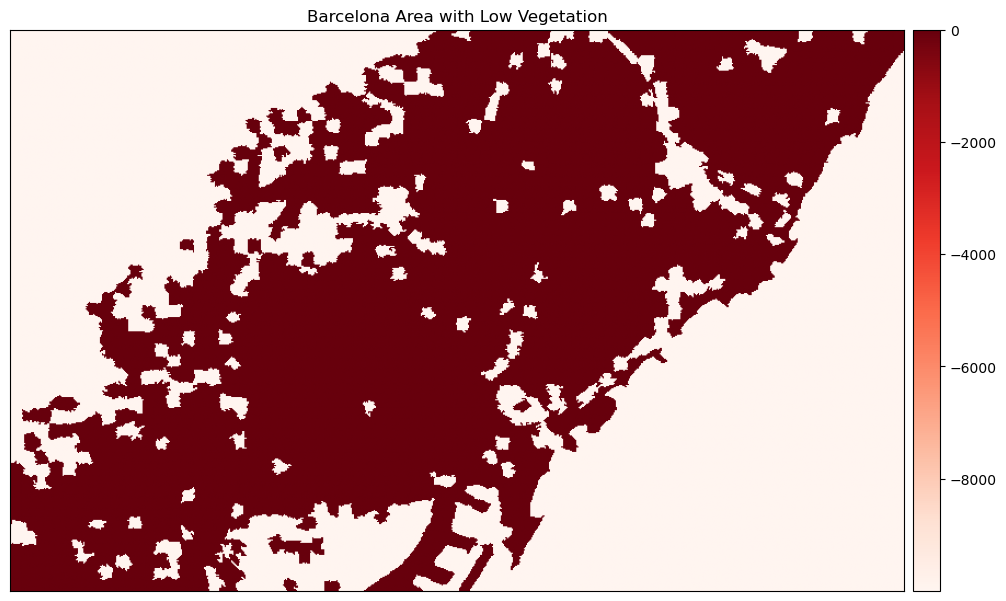

In [9]:
ep.plot_bands(no_sea, cmap = 'Reds', title = 'Barcelona Area with Low Vegetation')
plt.show()

# Type of Features

### 1) Spectral Features

Spectral features capture the radiometric properties of segments by analyzing pixel values across different spectral bands

#### 1.a) Intensity

In [10]:
def intensity_mean(seg_arr, img_arr):
    spectral_feature = regionprops_table(
        label_image = seg_arr, 
        intensity_image = img_arr,
        properties = ['label', 'intensity_mean']
    )
    return pd.DataFrame(spectral_feature)

In [11]:
img = np.dstack([
    stack[2,:,:], #Red
    stack[0,:,:], #Green
    stack[1,:,:], #Blue
    ndvi_hwb
    ])

#Creating segments in all bands from the stack
compactness = 0.3
n_segments = 3000

segments = slic(img, n_segments=n_segments, compactness=compactness, start_label=1)

In [12]:
means = intensity_mean(segments, img)
display(means)

label  intensity_mean-0  intensity_mean-1  intensity_mean-2  \
0         1          0.048433          0.103019          0.074044   
1         2          0.048680          0.103389          0.071483   
2         3          0.048800          0.103584          0.072599   
3         4          0.047309          0.103823          0.073033   
4         5          0.049846          0.103399          0.076160   
...     ...               ...               ...               ...   
2917   2918          0.033917          0.106972          0.060979   
2918   2919          0.033757          0.106857          0.060716   
2919   2920          0.033758          0.106790          0.060675   
2920   2921          0.033668          0.106532          0.060648   
2921   2922          0.048777          0.129530          0.092713   

      intensity_mean-3  
0             0.516658  
1             0.429305  
2             0.450858  
3             0.449159  
4             0.551454  
...                ...  
2917         -0.345525  
2918         -0.336853  
2919         -0.339478  
2920         -0.340452  
2921         -0.330039  

[2922 rows x 5 columns]

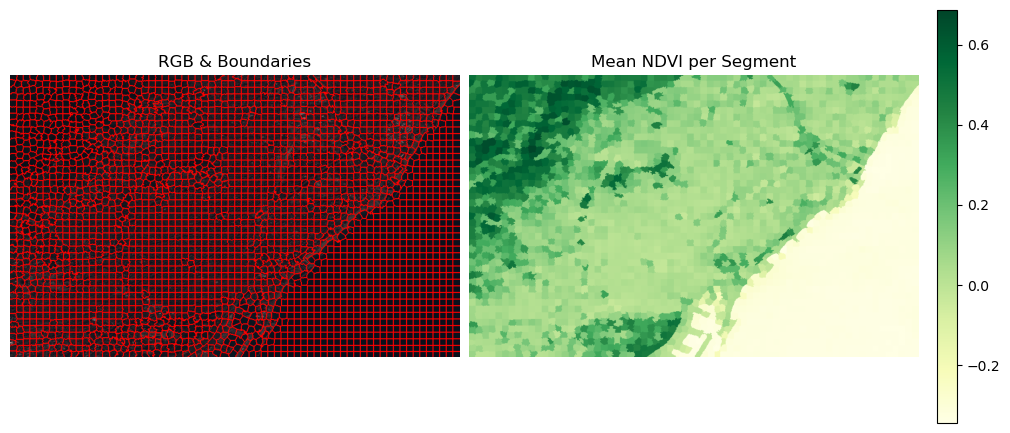

In [13]:

# Mapping NDVI mean values back to image segments
mapped_mean = map_array(
    segments,
    np.array(means["label"]),
    np.array(means["intensity_mean-3"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb_hwb, segments,  color=(1, 0, 0), mode="thick"))

im = axs[1].imshow(mapped_mean, cmap="YlGn")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("NDVI per Pixel")
axs[1].set_title("Mean NDVI per Segment")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()


#### 1.b) Standard Deviation

In [18]:
def std(regionmask, intensity_img):
    values = intensity_img[regionmask]
    std = np.std(values)
    return std

# Define a function to calculate standard deviation for all segments
def calc_std(seg_arr, img_arr):
    spectral_features = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label",],
        extra_properties=(std,)
        )
    return pd.DataFrame(spectral_features)

In [19]:
stds = calc_std(segments, img)
display(stds)

label     std-0     std-1     std-2     std-3
0         1  0.003873  0.002624  0.004815  0.071113
1         2  0.009876  0.005476  0.008066  0.085984
2         3  0.005835  0.003006  0.005923  0.111725
3         4  0.004752  0.003843  0.006271  0.111282
4         5  0.003581  0.002323  0.004150  0.053685
...     ...       ...       ...       ...       ...
2917   2918  0.000484  0.000768  0.000570  0.015403
2918   2919  0.000516  0.000669  0.000470  0.015290
2919   2920  0.000483  0.000669  0.000597  0.014687
2920   2921  0.000512  0.000753  0.000579  0.015167
2921   2922  0.010351  0.002776  0.004403  0.061062

[2922 rows x 5 columns]

In [ ]:
map_array(
    segments,
    np.array(stds["label"]),
    np.array(stds["std-3"])
)

(513, 817)

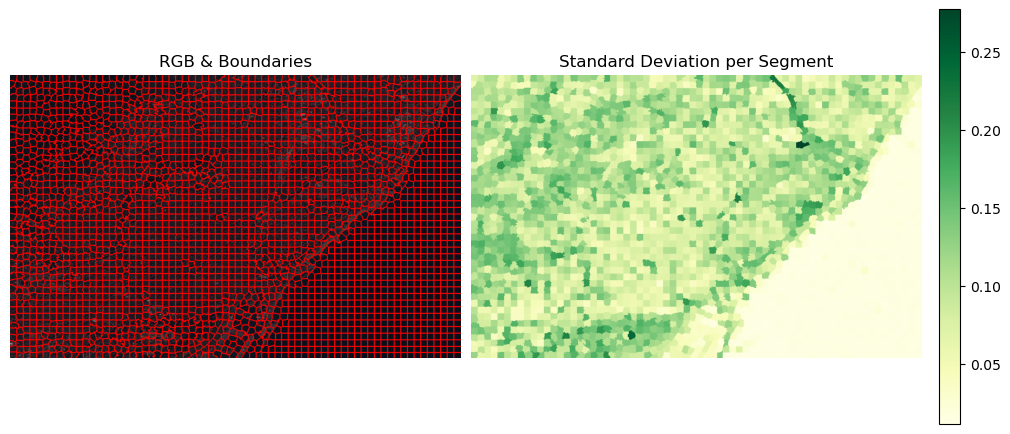

In [24]:
# Mapping stdv values back to image segments
mapped_std = map_array(
    segments,
    np.array(stds["label"]),
    np.array(stds["std-3"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb_hwb, segments,  color=(1, 0, 0), mode="thick"))

im = axs[1].imshow(mapped_std, cmap="YlGn")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("Standard Deviation per Segment")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()


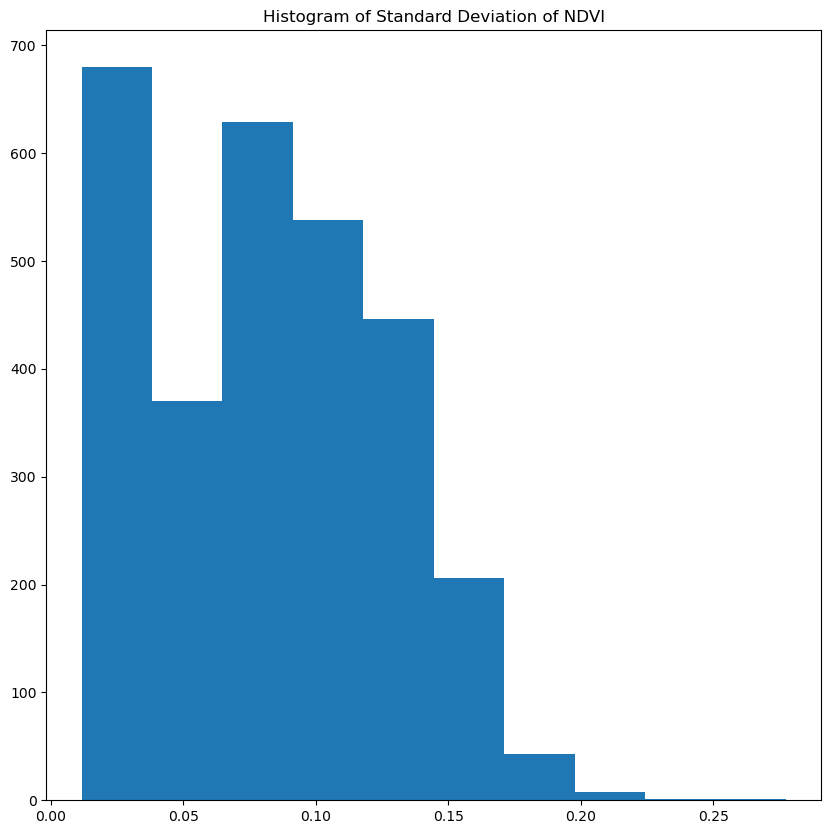

In [25]:
plt.hist(stds['std-3'])
plt.title('Histogram of Standard Deviation of NDVI')
plt.show()

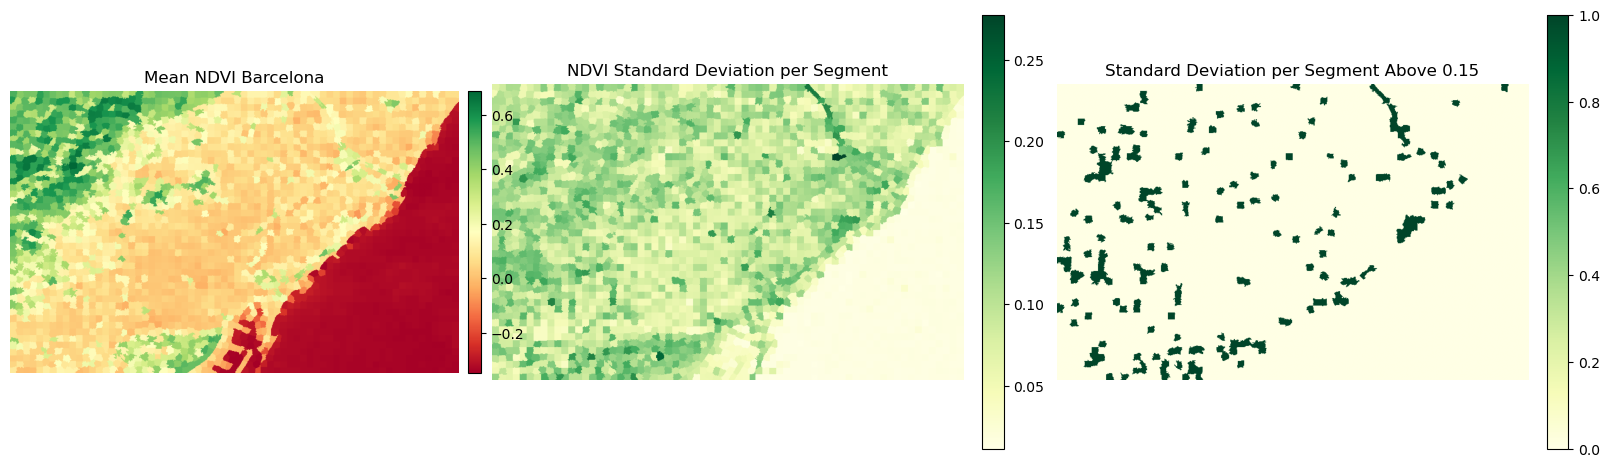

In [ ]:
#Cells in Barcelona where NDVI is above the mean (mix of health and stressed vegetation)


# Visualize the results
fig, axs = plt.subplots(ncols=3, figsize=(16,8), constrained_layout=True)
ep.plot_bands(mean_ndvi[0],  cmap = 'RdYlGn',title = 'Mean NDVI Barcelona',ax = axs[0])

im_std = axs[1].imshow(mapped_std, cmap = 'YlGn')
fig.colorbar(im_std, ax=axs[1], fraction=0.046, pad=0.04)

im = axs[2].imshow(mapped_std >= 0.15, cmap="YlGn")
fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)


axs[1].set_title("NDVI Standard Deviation per Segment")
axs[2].set_title("Standard Deviation per Segment Above 0.15")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()


## 2) Shape Features

#### 2.a) Retangularity

In [34]:
def rectangularity(regionmask):
    return regionmask.sum()/regionmask.size

def calc_rect_shapes(seg_arr):
    shp_feats = regionprops_table(
        label_image = seg_arr, 
        properties = ["label", "area_bbox"],
        extra_properties=(rectangularity,)
    )
    return pd.DataFrame(shp_feats)


In [ ]:
rects = calc_rect_shapes(segments)
rects

#Our segmentation is very homogeneous, therefore, the rectangularity is going to be very similar to all cells.

label  area_bbox  rectangularity
0         1      156.0        0.865385
1         2      156.0        0.910256
2         3      169.0        0.857988
3         4      168.0        0.851190
4         5      169.0        0.863905
...     ...        ...             ...
2917   2918      120.0        1.000000
2918   2919      120.0        1.000000
2919   2920      120.0        1.000000
2920   2921      130.0        1.000000
2921   2922      153.0        0.732026

[2922 rows x 3 columns]

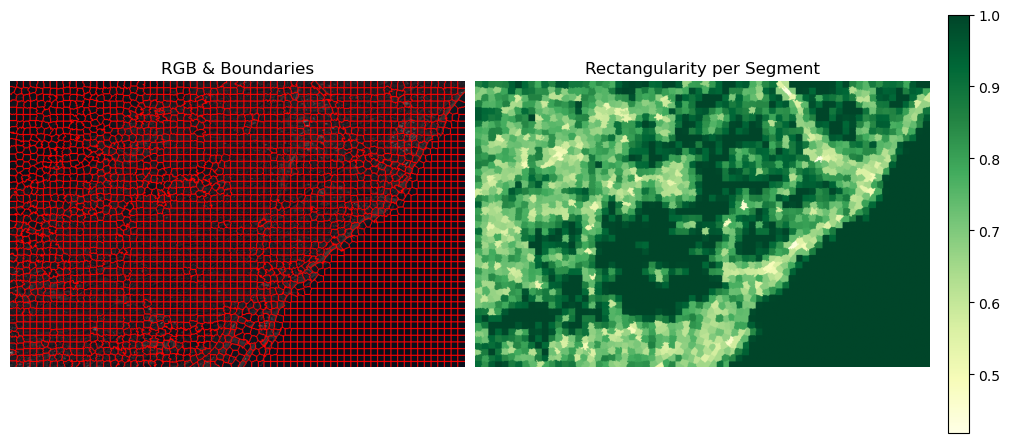

In [36]:
mapped_rectangularity = map_array(
    segments,
    np.array(rects["label"]),
    np.array(rects["rectangularity"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(10,5), constrained_layout=True)
axs[0].imshow(mark_boundaries(rgb_hwb, segments,  color=(1, 0, 0), mode="thick"))

im = axs[1].imshow(mapped_rectangularity, cmap="YlGn")
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

axs[0].set_title("RGB & Boundaries")
axs[1].set_title("Rectangularity per Segment")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()

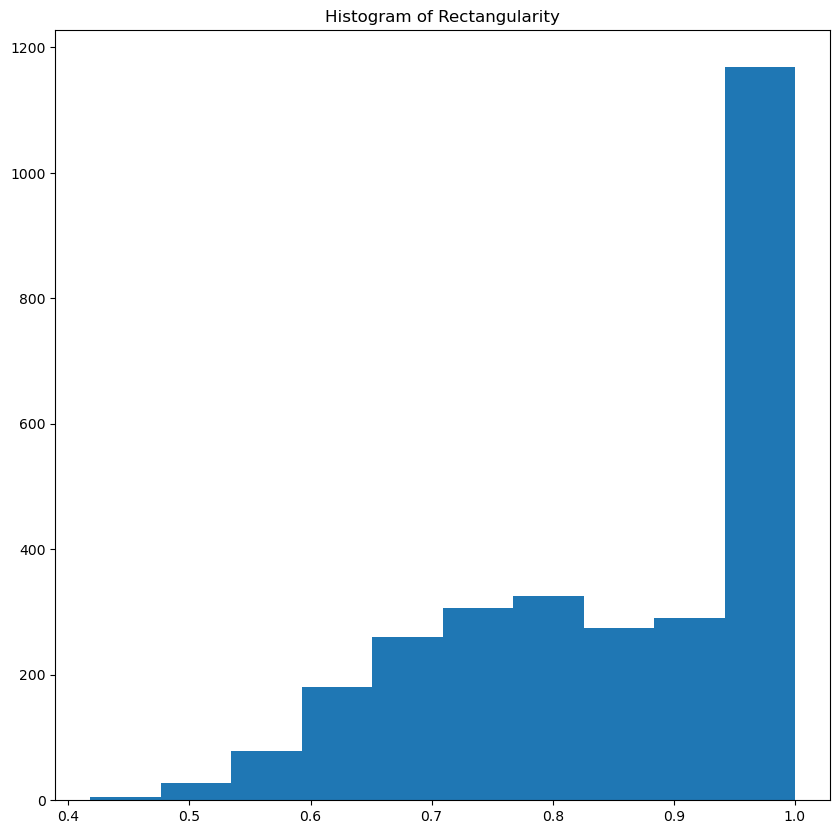

In [37]:
plt.hist(rects['rectangularity'])
plt.title('Histogram of Rectangularity')
plt.show()

#### 2.b) Compactness and Solidity

In [38]:
def calc_shapes(seg_arr, solidity=True):
    if solidity:
        props = ["label", "solidity", "area", "perimeter"]
    else:
        props = ["label", "area", "perimeter"]
    shp_feats = regionprops_table(
        label_image = seg_arr,
        properties = props,
        )
    compactness = 4*np.pi*shp_feats["area"]/(shp_feats["perimeter"]**2)
    shp_feats["compactness"] = compactness
    shp_feats.pop("area")
    shp_feats.pop("perimeter")
    return pd.DataFrame(shp_feats)

# Perform the shape calculations and display the results
shapes = calc_shapes(segments)
display(shapes)

label  solidity  compactness
0         1  0.944056     0.835118
1         2  0.959459     0.901707
2         3  0.947712     0.920757
3         4  0.922581     0.831601
4         5  0.948052     0.927107
...     ...       ...          ...
2917   2918  1.000000     0.942478
2918   2919  1.000000     0.942478
2919   2920  1.000000     0.942478
2920   2921  1.000000     0.926093
2921   2922  0.903226     0.710071

[2922 rows x 3 columns]

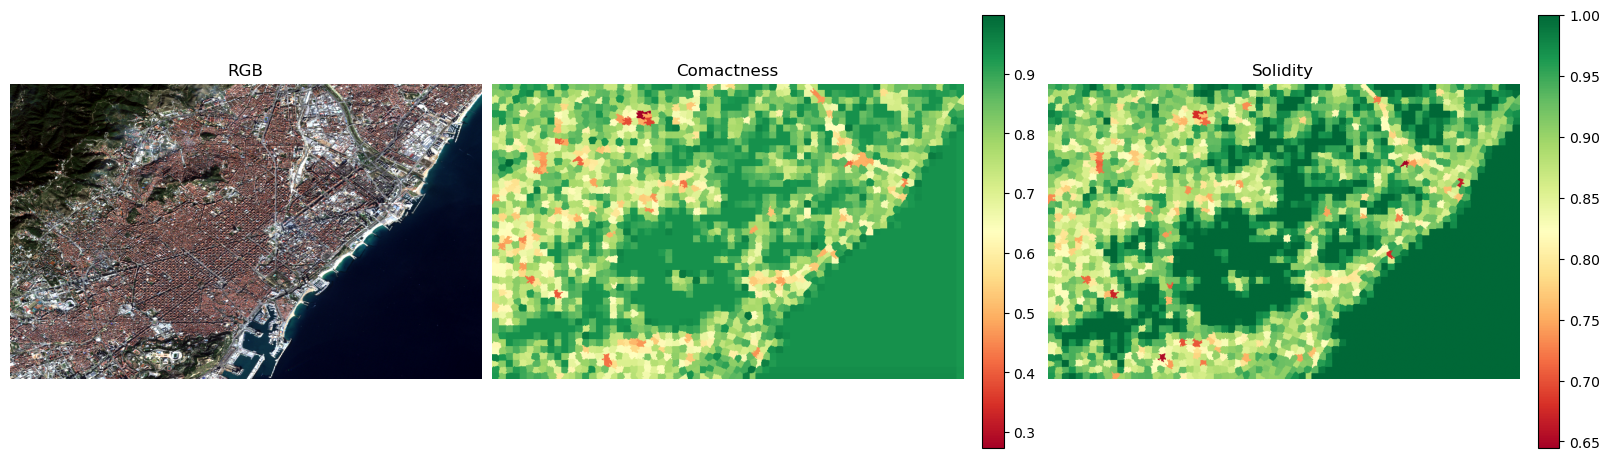

In [41]:
mapped_compactness = map_array(segments, np.array(shapes['label']), np.array(shapes['compactness']))
mapped_solidity = map_array(segments, np.array(shapes['label']), np.array(shapes['solidity']))

fig, axs = plt.subplots(ncols = 3, figsize = (16, 8), constrained_layout = True)

ep.plot_rgb(rgb, stretch=True, title = 'RGB Barcelona', ax = axs[0])

im_c = axs[1].imshow(mapped_compactness, cmap = "RdYlGn")
fig.colorbar(im_c, ax = axs[1], fraction = 0.046, pad = 0.04)

im_s = axs[2].imshow(mapped_solidity, cmap = "RdYlGn")
fig.colorbar(im_s, ax = axs[2], fraction = 0.046, pad = 0.04)

axs[0].set_title("RGB")
axs[1].set_title("Comactness")
axs[2].set_title("Solidity")

for ax in axs.flat:
    ax.set_axis_off()

plt.show()

## 3) Textural Features

#### 3.a) Entropy

In [48]:
def entropy_ndvi(regionmask, intensity_img):
    vals = intensity_img[regionmask]
    arr = stats.relfreq(vals, 100, defaultreallimits=(-1,1))[0]
    return stats.entropy(arr)

# Define a function to calculate entropy for all segments
def calc_entropy(seg_arr, img_arr):
    entropy_feats = regionprops_table(
        label_image = seg_arr,
        intensity_image = img_arr,
        properties = ["label"],
        extra_properties = (entropy_ndvi,)
        )
    return pd.DataFrame(entropy_feats)

# Perform the entropy calculation and display the results
entropy = calc_entropy(segments, ndvi_hwb)
display(entropy)

label  entropy_ndvi-0
0         1        2.528708
1         2        2.817825
2         3        2.909305
3         4        2.932781
4         5        2.182367
...     ...             ...
2917   2918        1.244924
2918   2919        1.188376
2919   2920        1.155622
2920   2921        1.224510
2921   2922        1.648801

[2922 rows x 2 columns]

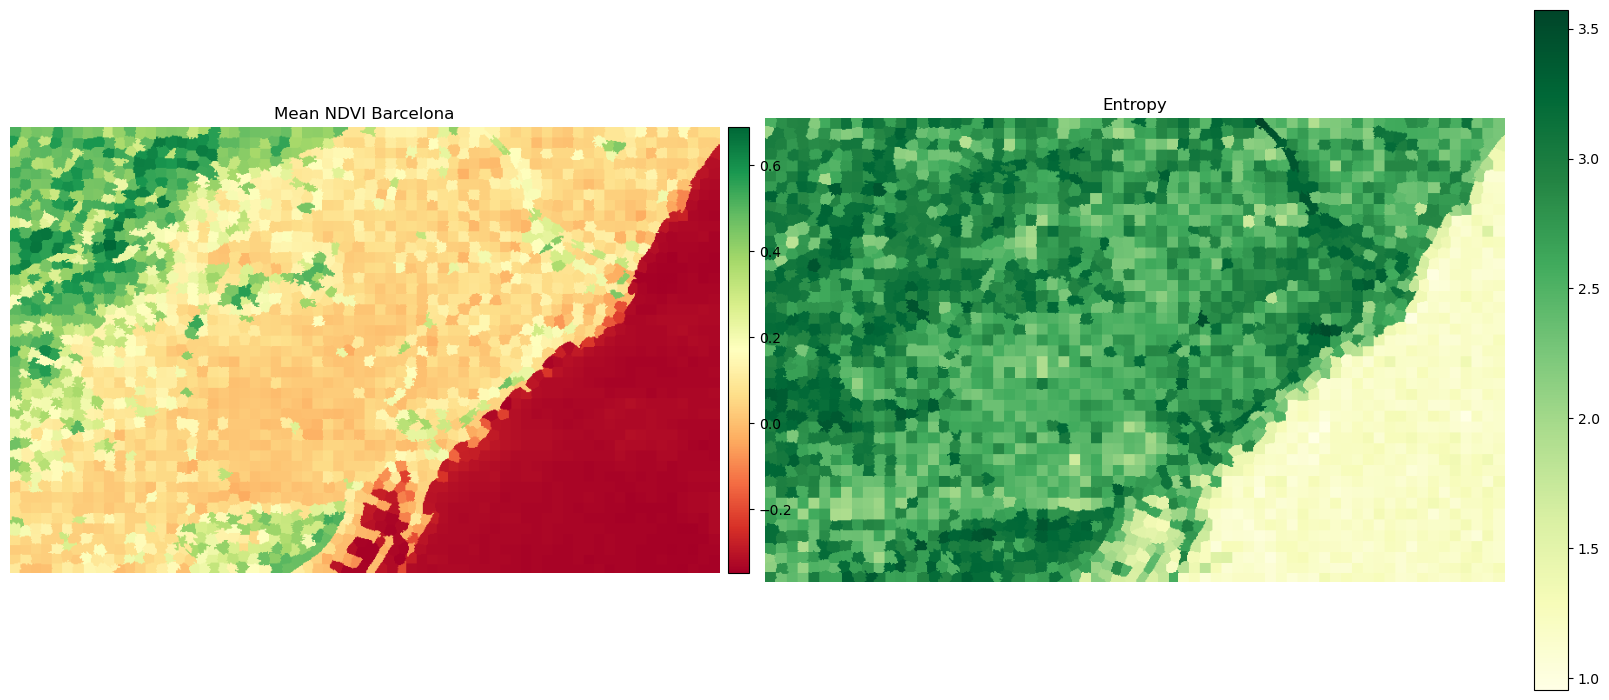

In [49]:
mapped_entropy = map_array(
    segments, np.unique(segments), np.array(entropy["entropy_ndvi-0"])
)

# Visualize the results
fig, axs = plt.subplots(ncols=2, figsize=(16,8), constrained_layout=True)
ep.plot_bands(mean_ndvi[0],  cmap = 'RdYlGn',title = 'Mean NDVI Barcelona',ax = axs[0])

im_ent = axs[1].imshow(mapped_entropy, cmap = 'YlGn')
fig.colorbar(im_ent, ax=axs[1], fraction=0.046, pad=0.04)
axs[1].set_title("Entropy")


for ax in axs.flat:
    ax.set_axis_off()

plt.show()
